In [1]:
import PIL
import numpy as np
import torch
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from tqdm import tqdm
from scipy.optimize import minimize
from vedo import *
import meshio
import seaborn as sns
import pyvista as pv
from data_processing.mesh_to_array import *
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from hydra import compose, initialize
from omegaconf import OmegaConf
from utils.helper import make_cmap, get_all_cases
import fnmatch
import cv2
from data_processing.dataset import load_dataset, get_epair_center
from data_processing.mesh_to_array import mesh_to_image
from data_processing.dataset_3d import make_npz_3d, load_dataset_3d, make_dataset_3d, make_npz_3d_multi, write_npz_case_3d
from data_processing.dataset_3d import change_rho
# from data_processing.obj2py import read_get
from utils.helper import make_cmap

In [2]:
def load_cfg(path):
    with initialize(version_base=None, config_path=path, job_name="test"):
        cfg = compose(config_name="config")
    return cfg

cmap = make_cmap()
cfg = load_cfg('cfg')

# Make 3d points

In [3]:
cfg.data.processed_data_folder = 'data/processed/3d'
cases = get_all_cases(cfg, base_dir='', use_raw=True)

In [4]:
cases = ['case_TCIA_110_0']

In [5]:
write_npz_case_3d(cases[0], resolution=512, electrode_resolution=512, all_signals=True, points_3d=True)

here


: 

In [4]:
train_dataset, val_dataset, test_dataset = load_dataset_3d(cases,
                write_dataset=True, write_npz=True, points_3d=True, processed_data_folder='data/processed/3d', overwrite_npz=True, 
                base_dir='', resolution=512, electrode_resolution=512, all_signals=True)

Processing items:   0%|          | 0/2 [04:38<?, ?it/s]


IndexError: index 4 is out of bounds for axis 0 with size 4

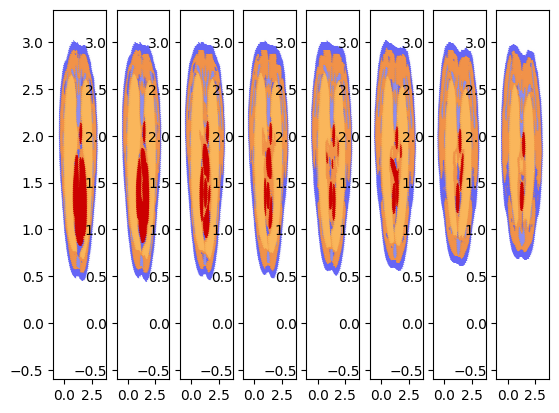

In [10]:
fig, axes = plt.subplots(1,8)
tmp_points = train_dataset.points.reshape(8, 4, -1, 8, 3)
for i in range(8):
    # axes[i].imshow(train_dataset.targets[4,0,:,:,i], cmap=cmap)
    axes[i].scatter(tmp_points[0,0,:,i,0], tmp_points[0,0,:,i,1], marker='.', c=(train_dataset.targets[0,0,:,:,i].reshape(-1)), cmap=cmap, s=1)


In [7]:
test = np.load('/home/nibdombe/deep_eit/data/processed/case_TCIA_2_0.npz')

In [19]:
targets = test['targets']
targets = np.moveaxis(targets.reshape(4,4,512,512,1),0,1)

In [36]:
test['points'].shape

(16, 262144, 3)

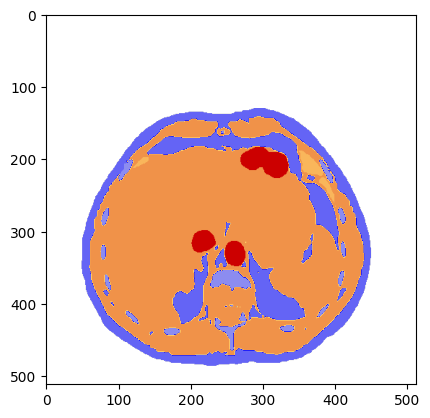

In [30]:
plt.imshow(targets[0,2], cmap=cmap)

In [17]:
targets.shape

(16, 512, 512, 1)

# Show slice from .nas

In [3]:
from data_processing.preprocessing import load_mask_target_electrodes
import matplotlib.pyplot as plt

In [4]:
mesh_data = load_mask_target_electrodes('/home/nibdombe/deep_eit/data/raw/case_TCIA_250_0', resolution=512)

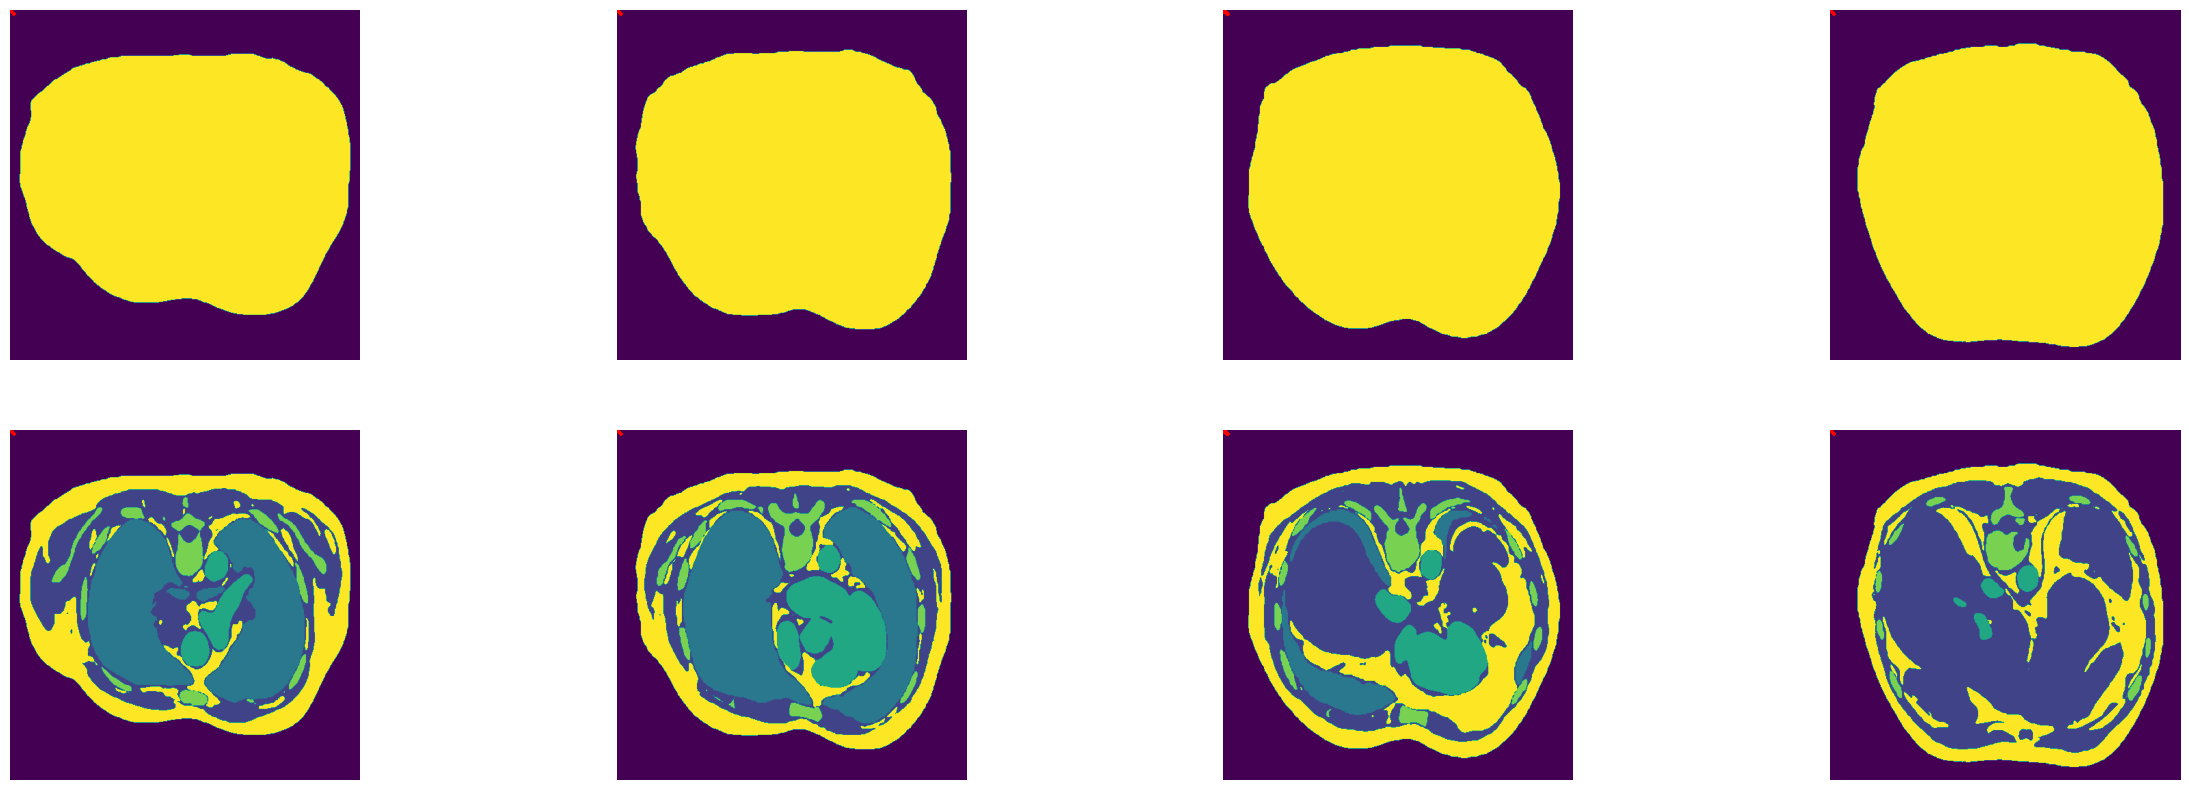

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
for i in range(4):
    axes[0,i].imshow(mesh_data[0][i])
    axes[0,i].axis('off')
    axes[0,i].scatter(mesh_data[-1][i][:,0], mesh_data[-1][i][:,1], marker='x', c='r')
    axes[1,i].imshow(mesh_data[1][i])
    axes[1,i].axis('off')
    axes[1,i].scatter(mesh_data[-1][i][:,0], mesh_data[-1][i][:,1], marker='x', c='r')



# Check data from .npz files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Individual case

In [27]:
data = np.load('/home/nibdombe/deep_eit/data/processed/3d/case_TCIA_2_0/case_TCIA_2_0_20.npz')
print(
    data['targets'].shape,
    data['points'].shape,
    data['electrodes'].shape,
    data['masks'].shape,
    data['signals'].shape
)

(6, 512, 512) (6, 262144, 3) (4, 16, 13, 4, 3) (6, 512, 512) (4, 208)


In [28]:
targets = data['targets']
points = data['points']
electrodes = data['electrodes']

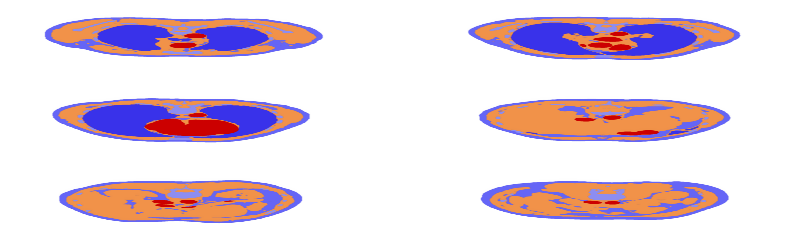

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(10, 3))
for i, ax in enumerate(axes.flatten()):
    # ax.imshow(targets[i], cmap=cmap)
    ax.axis('off')
    ax.scatter(points[i][:,0], points[i][:,1], marker='.', c=(targets[i].reshape(-1)), cmap=cmap, s=1)
    # ax.scatter(electrodes[i][0,0],electrodes[i][0,1], marker='x', c='r', s=50)

## Check all cases

In [8]:
path = '/home/nibdombe/deep_eit/data/processed/'
cases = os.listdir(path)
cases = [case for case in cases if fnmatch.fnmatch(case, 'case_TCIA*')]


### Electrode position

 10%|▉         | 23/238 [00:05<00:56,  3.81it/s]

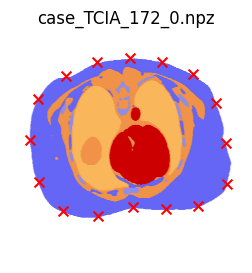

 73%|███████▎  | 173/238 [00:46<00:16,  3.93it/s]

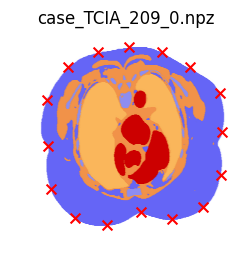

100%|██████████| 238/238 [01:05<00:00,  3.66it/s]


In [22]:
for i, case in enumerate(tqdm(cases)):
    case_path = os.path.join(path, case) 
    data = np.load(case_path)
    targets = data['targets']
    points = data['points']
    electrodes = data['electrodes']
    idx = np.where(targets[0].reshape(-1) != 0.)[0]
    rel_points = points[0][idx]
    min_x = np.min(rel_points[:,0])
    max_x = np.max(rel_points[:,0])
    min_y = np.min(rel_points[:,1])
    max_y = np.max(rel_points[:,1])
    
    min_x_electrodes = np.min(electrodes[0][:,0])
    max_x_electrodes = np.max(electrodes[0][:,0])
    min_y_electrodes = np.min(electrodes[0][:,1])
    max_y_electrodes = np.max(electrodes[0][:,1])

    distances = np.array([min_x - min_x_electrodes,
        max_x - max_x_electrodes,
        min_y - min_y_electrodes,
        max_y - max_y_electrodes])
    if np.any(np.abs(distances) > 0.01):
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.axis('off')
        ax.scatter(points[0][:,0], points[0][:,1], marker='.', c=(targets[0].reshape(-1)), cmap=cmap, s=1)
        ax.scatter(electrodes[0][:,0],electrodes[0][:,1], marker='x', c='r', s=50)
        ax.set_title(case)
        plt.show()
        plt.close()

# Check signals scale

 47%|████▋     | 113/238 [00:09<00:10, 12.08it/s]


KeyboardInterrupt: 

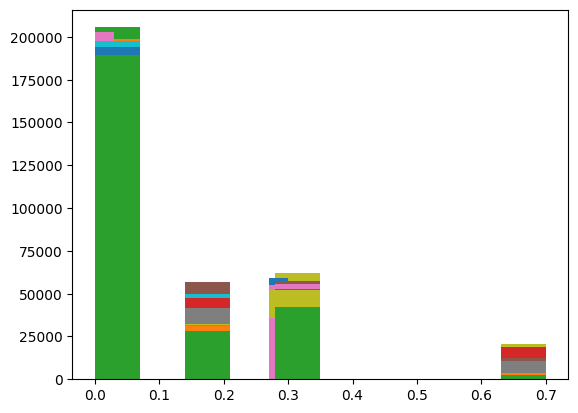

In [24]:
for i, case in enumerate(tqdm(cases)):
    case_path = os.path.join(path, case) 
    data = np.load(case_path)
    signals = data['targets']
    plt.hist(signals[0].flatten())
    plt.show()

## Check all cases visually

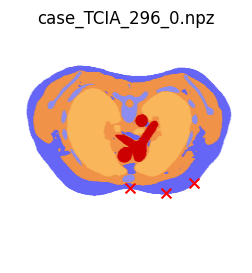

In [29]:
for i, case in enumerate(cases):
    case_path = os.path.join(path, case) 
    data = np.load(case_path)
    targets = data['targets']
    points = data['points']
    electrodes = data['electrodes']
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.axis('off')
    ax.scatter(points[0][:,0], points[0][:,1], marker='.', c=(targets[0].reshape(-1)), cmap=cmap, s=1)
    ax.scatter(electrodes[0][:3,0],electrodes[0][:3,1], marker='x', c='r', s=50)
    ax.set_title(case)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.show()
    plt.close()


# Check dataset files

In [5]:
train_dataset = torch.load('data/datasets/train_dataset.pt')

In [12]:
train_dataset.cases

['case_TCIA_6_0',
 'case_TCIA_179_0',
 'case_TCIA_140_0',
 'case_TCIA_263_0',
 'case_TCIA_109_0',
 'case_TCIA_101_0',
 'case_TCIA_25_0',
 'case_TCIA_183_0',
 'case_TCIA_349_0',
 'case_TCIA_248_0',
 'case_TCIA_213_0',
 'case_TCIA_345_0',
 'case_TCIA_127_0',
 'case_TCIA_273_0',
 'case_TCIA_196_0',
 'case_TCIA_393_0',
 'case_TCIA_175_0',
 'case_TCIA_135_0',
 'case_TCIA_110_0',
 'case_TCIA_112_0',
 'case_TCIA_268_0',
 'case_TCIA_20_0',
 'case_TCIA_199_0',
 'case_TCIA_172_0',
 'case_TCIA_389_0',
 'case_TCIA_274_0',
 'case_TCIA_124_0',
 'case_TCIA_366_0',
 'case_TCIA_21_0',
 'case_TCIA_144_0',
 'case_TCIA_365_0',
 'case_TCIA_177_0',
 'case_TCIA_238_0',
 'case_TCIA_289_0',
 'case_TCIA_229_0',
 'case_TCIA_217_0',
 'case_TCIA_168_0',
 'case_TCIA_290_0',
 'case_TCIA_249_0',
 'case_TCIA_341_0',
 'case_TCIA_138_0',
 'case_TCIA_158_0',
 'case_TCIA_211_0',
 'case_TCIA_299_0',
 'case_TCIA_247_0',
 'case_TCIA_26_0',
 'case_TCIA_373_0',
 'case_TCIA_120_0',
 'case_TCIA_192_0',
 'case_TCIA_203_0',
 'case

In [13]:
len(train_dataset.cases)

189

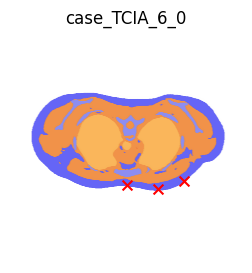

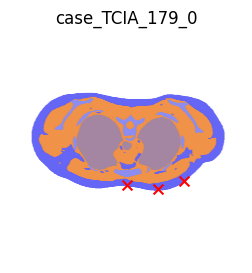

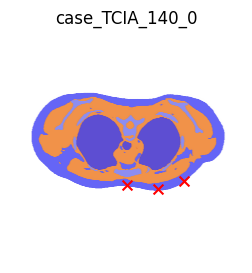

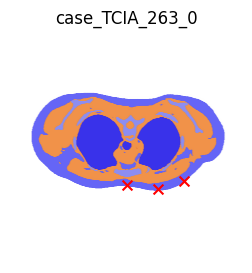

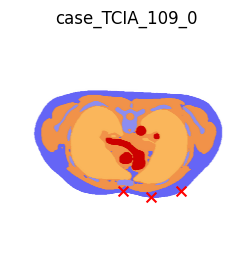

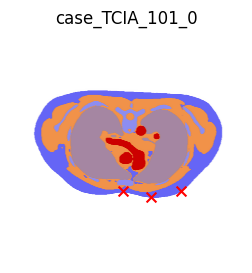

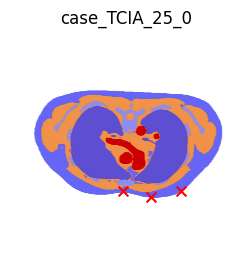

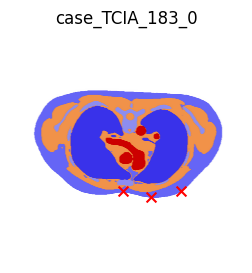

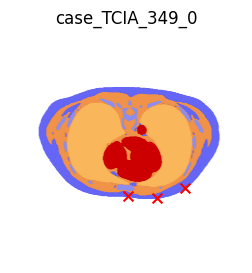

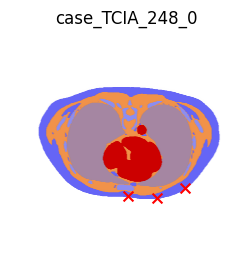

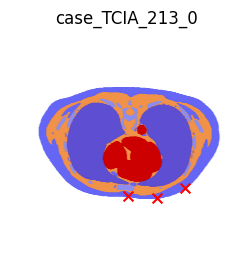

In [20]:
for i in range(len(train_dataset)):
    targets = train_dataset.targets[i]
    points = train_dataset.points[i]
    electrodes = train_dataset.electrodes[i,:,0,0]
    case = train_dataset.cases[i]
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.axis('off')
    ax.scatter(points[:,0], points[:,1], marker='.', c=(targets.reshape(-1)), cmap=cmap, s=1)
    ax.scatter(electrodes[:3,0],electrodes[:3,1], marker='x', c='r', s=50)
    ax.set_title(case)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.show()
    plt.close()
    if i==10:
        break

In [18]:
electrodes.shape

torch.Size([16, 13, 4, 3])

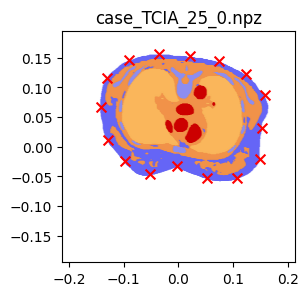

In [12]:
case = 'case_TCIA_25_0.npz'
case_path = os.path.join(path, case) 
data = np.load(case_path)
targets = data['targets']
points = data['points']
electrodes = data['electrodes']
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(points[0][:,0], points[0][:,1], marker='.', c=(targets[0].reshape(-1)), cmap=cmap, s=1)
ax.scatter(electrodes[0][:16,0], electrodes[0][:16,1], marker='x', c='r', s=50)
ax.set_title(case)
plt.show()
plt.close()


In [17]:
electrodes[0]

array([[-0.00274826, -0.3489681 ,  0.99134803],
       [ 0.05165074, -0.32951709,  0.98036517],
       [ 0.10690474, -0.32925509,  0.98719983],
       [ 0.14836874, -0.36055209,  0.98099728],
       [ 0.15241674, -0.41425409,  1.        ],
       [ 0.15744074, -0.4699641 ,  0.98120798],
       [ 0.12311474, -0.5048091 ,  0.98989946],
       [ 0.07346774, -0.52664009,  0.99396864],
       [ 0.02060274, -0.53490709,  0.9881875 ],
       [-0.03582326, -0.53901509,  0.98518499],
       [-0.09038226, -0.52860409,  0.99491681],
       [-0.13087226, -0.4984301 ,  0.97910096],
       [-0.14174926, -0.44809509,  0.98867475],
       [-0.12920326, -0.39365809,  0.99327069],
       [-0.09790326, -0.35792209,  0.992125  ],
       [-0.05256126, -0.33538009,  0.99208549]])

In [ ]:
for i, case in enumerate(cases):
    case_path = os.path.join(path, case) 
    data = np.load(case_path)
    targets = data['targets']
    points = data['points']
    electrodes = data['electrodes']
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.axis('off')
    ax.scatter(points[0][:,0], points[0][:,1], marker='.', c=(targets[0].reshape(-1)), cmap=cmap, s=1)
    ax.scatter(electrodes[0][:3,0],electrodes[0][:3,1], marker='x', c='r', s=50)
    ax.set_title(case)
    plt.show()
    plt.close()


In [6]:
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(points[i][:,0], points[i][:,1], marker='.', c=(targets[i].reshape(-1)))
    ax.axis('off')
    ax.scatter(electrodes[i][:,0], electrodes[i][:,1], marker='x', c='r')

Error in callback <function _draw_all_if_interactive at 0x7fff1491d870> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define the colors and their positions in the colormap
colors = [(1., 1., 1),   # blue
          (0.1, 0.1, 1), # light blue
          (1, 0.8, 0.4), # yellow
          (0.8, 0, 0)]     # red
positions = [0.0, 0.05, 0.2, 1.0]

# Create the colormap
cmap = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors)))



In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(targets[i].squeeze(), cmap=cmap, ax=ax)
    ax.axis('off')
    ax.scatter(electrodes[i][:,0], electrodes[i][:,1], marker='x', c='r', legend='Electrodes')

# Load from datasets

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
dataset = torch.load('/home/nibdombe/deep_eit/data/datasets/test_dataset.pt')

In [5]:
dataset.use_epair_center = True

In [6]:
dataset.cases

['case_TCIA_105_0',
 'case_TCIA_288_0',
 'case_TCIA_196_0',
 'case_TCIA_270_0',
 'case_TCIA_127_0',
 'case_TCIA_214_0',
 'case_TCIA_125_0',
 'case_TCIA_249_0',
 'case_TCIA_194_0',
 'case_TCIA_267_0',
 'case_TCIA_286_0',
 'case_TCIA_250_0',
 'case_TCIA_21_0',
 'case_TCIA_342_0',
 'case_TCIA_235_0',
 'case_TCIA_178_0',
 'case_TCIA_220_0',
 'case_TCIA_362_0',
 'case_TCIA_234_0',
 'case_TCIA_223_0',
 'case_TCIA_135_0',
 'case_TCIA_193_0',
 'case_TCIA_10_0']

In [7]:
idx = np.where(np.array(dataset.cases) == 'case_TCIA_194_0')[0]

In [10]:
electrodes = dataset.electrodes.reshape(-1, 4, 4, 16, 3)
epair_center = np.array(dataset.epair_center).reshape(-1, 4, 4, 16, 2)
targets = dataset.targets.reshape(-1, 4, 4, int(512**2), 1)
points = dataset.points.reshape(-1, 4, 4, int(512**2), 3)

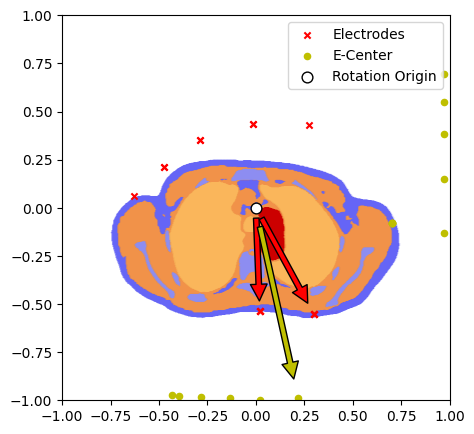

In [11]:
cmap = make_cmap()
e = electrodes[idx,0, 0,:,:2].squeeze()
c = epair_center[idx,0,0,:].squeeze()
t = targets[idx,0, 0]
p = points[idx,0, 0].squeeze()
fig, ax = plt.subplots(figsize=(5, 5))
# ax.imshow(t.squeeze())
ax.scatter(p[:,0], -1*p[:,1], marker='x', c=t.flatten(), s=.1, cmap=cmap)
ax.scatter(e[:,0], -1*e[:,1], marker='x', c='r', s=20, label='Electrodes')
ax.scatter(c[:,0], -1*c[:,1], marker='o', c='y', s=20, label='E-Center')
ax.scatter(0, 0, marker='o', c='white', edgecolors='black', s=60, label='Rotation Origin')
ax.annotate('', xy=(e[0,0], -1*e[0,1]), xytext=(0, 0),
             arrowprops=dict(facecolor='red', shrink=0.1))
ax.annotate('', xy=(e[1,0], -1*e[1,1]), xytext=(0, 0),
             arrowprops=dict(facecolor='red', shrink=0.1))
ax.annotate('', xy=(c[0,0], -1*c[0,1]), xytext=(0, 0),
             arrowprops=dict(facecolor='y', shrink=0.1))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.legend()

In [12]:
def show_rotation(angles):
    if isinstance(angles, int):
        angles = [angles]
    fig, axes = plt.subplots(1, len(angles), figsize=(int(5*len(angles)), 5))
    if len(angles) == 1:
        axes = [axes]
    for i, angle in enumerate(angles):
        rad_angle = torch.deg2rad(torch.tensor(angle))
        rot = dataset._random_rotation_matrix(rotation_angle=rad_angle)
        e_rot = torch.matmul(e, rot)
        p_rot = torch.matmul(p[:,:2].float(), rot)
        c_rot = torch.matmul(torch.from_numpy(c), rot)

        # fig, ax = plt.subplots(figsize=(5, 5))
        # ax.imshow(t.squeeze())
        axes[i].scatter(p_rot[:,0], -1*p_rot[:,1], marker='x', c=t.flatten(), s=.1, cmap=cmap)
        axes[i].scatter(e_rot[:,0], -1*e_rot[:,1], marker='x', c='r', s=20, label='Electrodes')
        axes[i].scatter(c_rot[:,0], -1*c_rot[:,1], marker='o', c='y', s=20, label='E-Center')
        axes[i].scatter(0, 0, marker='o', c='white', edgecolors='black', s=60, label='Rotation Origin')
        axes[i].annotate('', xy=(e_rot[0,0], -1*e_rot[0,1]), xytext=(0, 0),
                    arrowprops=dict(facecolor='red', shrink=0.1))
        axes[i].annotate('', xy=(e_rot[1,0], -1*e_rot[1,1]), xytext=(0, 0),
                    arrowprops=dict(facecolor='red', shrink=0.1))
        axes[i].annotate('', xy=(c_rot[0,0], -1*c_rot[0,1]), xytext=(0, 0),
                    arrowprops=dict(facecolor='y', shrink=0.1))
        axes[i].set_xlim(-1, 1)
        axes[i].set_ylim(-1, 1)
        axes[i]. set_title(f'Rotation Angle: {angle}')
        if i == len(angles)-1:
            axes[i].legend()


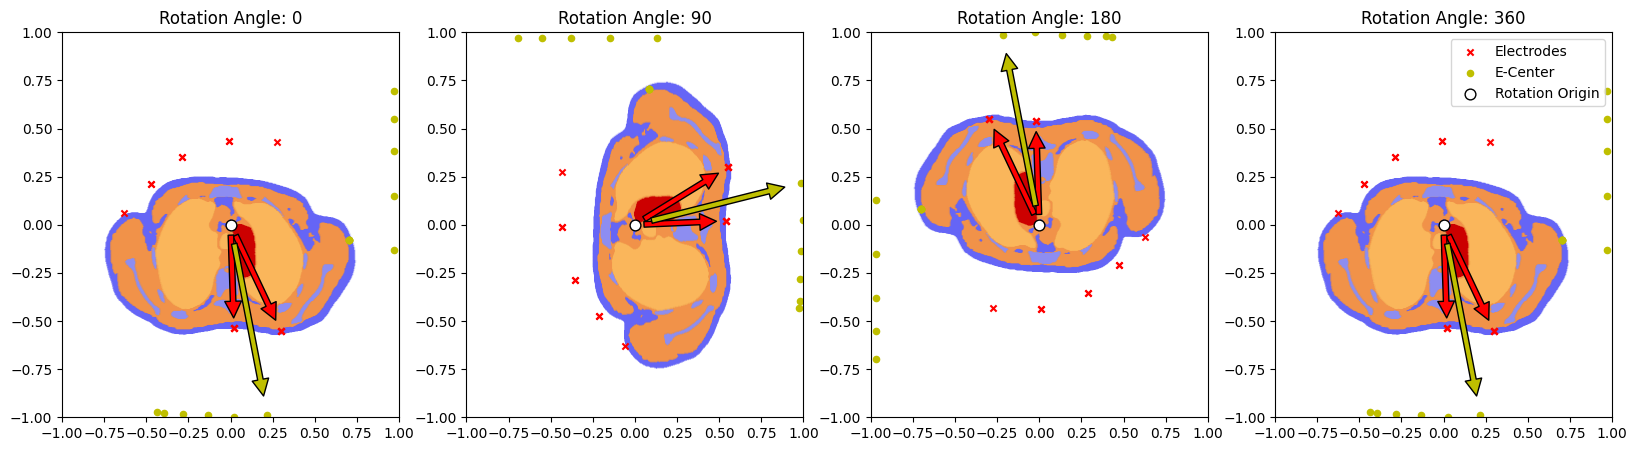

In [13]:
show_rotation([0, 90, 180,360])

In [14]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=3, shuffle=True)

In [16]:
for p, _, s, e, m, t in dl:
    points = p
    targets = t
    electrodes = e
    break

In [18]:
rot = dataset._random_rotation_matrix(torch.deg2rad(torch.tensor(90)))

(-1.0, 1.0)

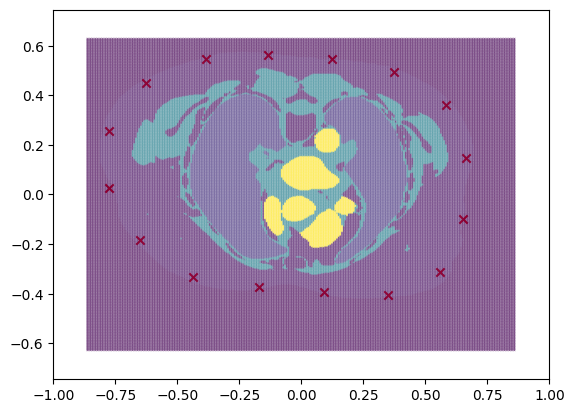

In [35]:
plt.scatter(electrodes[0,:,0,0,0], electrodes[0,:,0,0,1], marker='x', c='r')
plt.scatter(points[0,::2,0], points[0,::2,1], marker='x',s=0.01, c=targets[0,::2])

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


In [33]:
electrodes_rot = torch.matmul(electrodes[:,:,:,:,:2], rot)
points_rot = torch.matmul(points, rot)

(-1.0, 1.0)

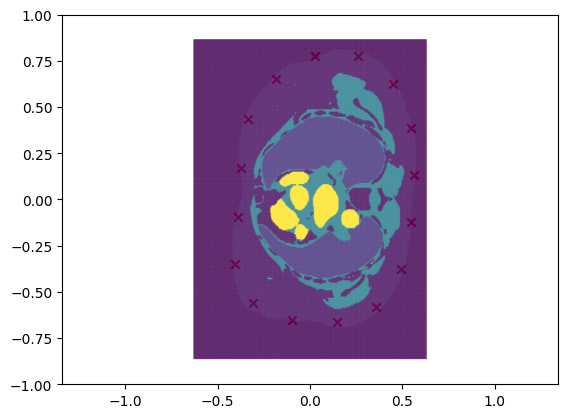

In [36]:
plt.scatter(electrodes_rot[0,:,0,0,0], electrodes_rot[0,:,0,0,1], marker='x', c='r')
plt.scatter(points_rot[0,::2,0], points_rot[0,::2,1], marker='x',s=0.01, c=targets[0,::2])
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


In [28]:
points.shape

torch.Size([3, 262144, 2])

# Compare generated targets with Anita's targets

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
toy = np.load('/work/deep_eit/data/processed/case_TCIA_53_0.npz', allow_pickle=True)

In [ ]:
toy['targets'].shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(toy['targets'][0].squeeze(), ax=axes[0])
axes[0].axis('off')
sns.heatmap(toy['targets'][1].squeeze(), ax=axes[1])

In [ ]:
anita_target = sio.loadmat('/work/deep_eit/data/raw/case_TCIA_53_0/targets/level_1.mat')['slice_z1']
anita_target = np.where(np.isnan(anita_target), 0, anita_target)
anita_target = np.moveaxis(anita_target, 0, 1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(toy['targets'][0].squeeze(), ax=axes[0], vmax=1)
axes[0].axis('off')
sns.heatmap(anita_target, ax=axes[1], vmax=1)
axes[1].axis('off')


In [ ]:
anita_target.shape

In [ ]:
np.unique(anita_target)

In [ ]:
import os


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF

In [2]:
from data_processing.mesh_to_array import mesh_to_image

In [3]:
mesh = '/home/nibdombe/deep_eit/data/raw/case_TCIA_21_0/shape/mesh.vtk'   

In [4]:
res = mesh_to_image(mesh, resolution=512)

Loading .vtk file...- Complete.
z_pos set to 1.28375.
Points: (262144, 3) Mean: (3,) Channelwise mean (262144,)


In [12]:
points = np.asarray(res[1].points)

In [13]:
points.shape

(262144, 3)

In [14]:
points_re = points.reshape(512,512,3)

In [16]:
res[0].shape

(512, 512, 1)

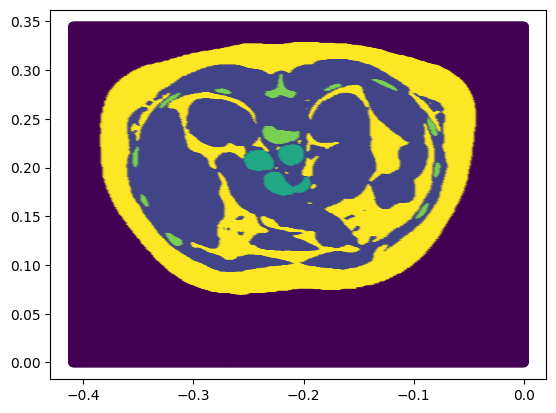

In [19]:
plt.scatter(points[:,0], points[:,1], c=res[0].flatten())

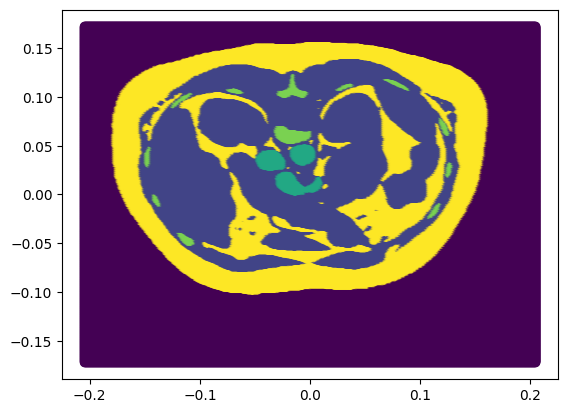

In [20]:
points_res = points - np.mean(points, axis=0)
plt.scatter(points_res[:,0], points_res[:,1], c=res[0].flatten())

In [8]:
from model.positional_encoding import positional_encoding
import torch

In [24]:
coord = torch.tensor([[torch.pi,-torch.pi,torch.pi, 1],
                     [4,5,6,5],
                     [7,8,9,29]])
print(coord.shape)                     

torch.Size([3, 4])


In [25]:
coord_pe = positional_encoding(coord, num_encoding_functions=2)
print(coord_pe.shape)

torch.Size([3, 16])


In [26]:
coord_pe[0]

tensor([-9.7537e-01,  9.7537e-01, -9.7537e-01,  1.0000e+00,  2.2058e-01,
         2.2058e-01,  2.2058e-01, -4.3711e-08, -4.3030e-01,  4.3030e-01,
        -4.3030e-01, -8.7423e-08, -9.0269e-01, -9.0269e-01, -9.0269e-01,
        -1.0000e+00])

In [27]:
coord_pe_0 = positional_encoding(coord[0], num_encoding_functions=2)

In [28]:
print(coord_pe_0)
print(coord_pe[0])

tensor([-9.7537e-01,  9.7537e-01, -9.7537e-01,  1.0000e+00,  2.2058e-01,
         2.2058e-01,  2.2058e-01, -4.3711e-08, -4.3030e-01,  4.3030e-01,
        -4.3030e-01, -8.7423e-08, -9.0269e-01, -9.0269e-01, -9.0269e-01,
        -1.0000e+00])
tensor([-9.7537e-01,  9.7537e-01, -9.7537e-01,  1.0000e+00,  2.2058e-01,
         2.2058e-01,  2.2058e-01, -4.3711e-08, -4.3030e-01,  4.3030e-01,
        -4.3030e-01, -8.7423e-08, -9.0269e-01, -9.0269e-01, -9.0269e-01,
        -1.0000e+00])


In [30]:
coord_more_dim = positional_encoding(coord.reshape(3,2,2), num_encoding_functions=2)

In [32]:
torch.all(coord_pe_0 == coord_more_dim[0].flatten())

tensor(False)

In [37]:
coord_more_dim_pe = coord_more_dim[0].flatten()

In [39]:
torch.sort(coord_more_dim_pe)[0] == torch.sort(coord_pe_0)[0]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])